# On-Device Continual Learning - EMNIST Classification

In [39]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## Model

### Load Dataset

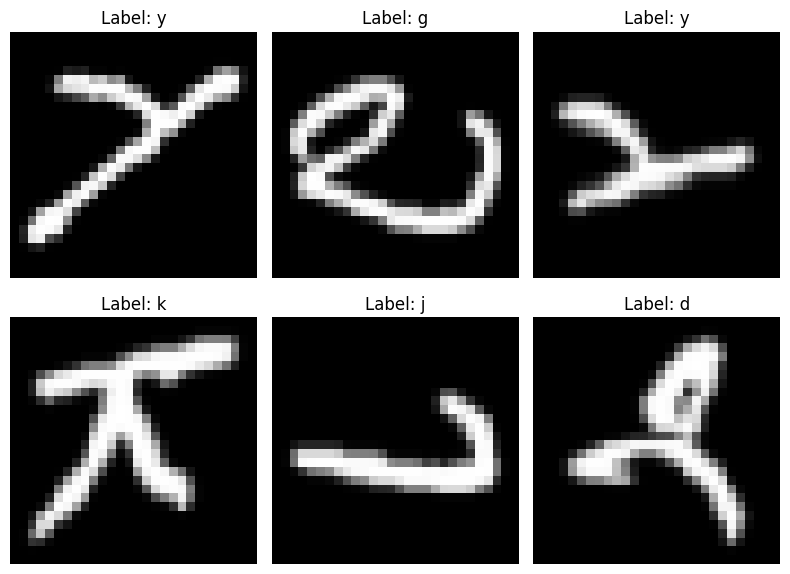

In [40]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

label_to_char = {i: chr(97 + i) for i in range(26)}

fig, axes = plt.subplots(2, 3, figsize=(8, 6))
for i, example in enumerate(ds_train.take(6)):
    image, label = example
    ax = axes[i // 3, i % 3]
    ax.imshow(tf.squeeze(image), cmap='gray')
    ax.set_title(f'Label: {label_to_char[label.numpy()-1]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


### Preprocess Dataset

In [41]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label - 1  # Labels are from 1 to 26 in this dataset

BATCH_SIZE = 64

ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Model Definition

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

### Training

In [43]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_test, epochs=5)

Epoch 1/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6602 - loss: 1.1538 - val_accuracy: 0.8624 - val_loss: 0.4272
Epoch 2/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8856 - loss: 0.3588 - val_accuracy: 0.8889 - val_loss: 0.3421
Epoch 3/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9070 - loss: 0.2868 - val_accuracy: 0.8949 - val_loss: 0.3220
Epoch 4/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9193 - loss: 0.2471 - val_accuracy: 0.9066 - val_loss: 0.2903
Epoch 5/5
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9267 - loss: 0.2184 - val_accuracy: 0.9088 - val_loss: 0.2838


### Mdel Evaluation

In [58]:
test_loss, test_acc = model.evaluate(ds_test)
print(f'\nTest accuracy: {test_acc:.4f}')

232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2124 - loss: 2.9232

Test accuracy: 0.2161


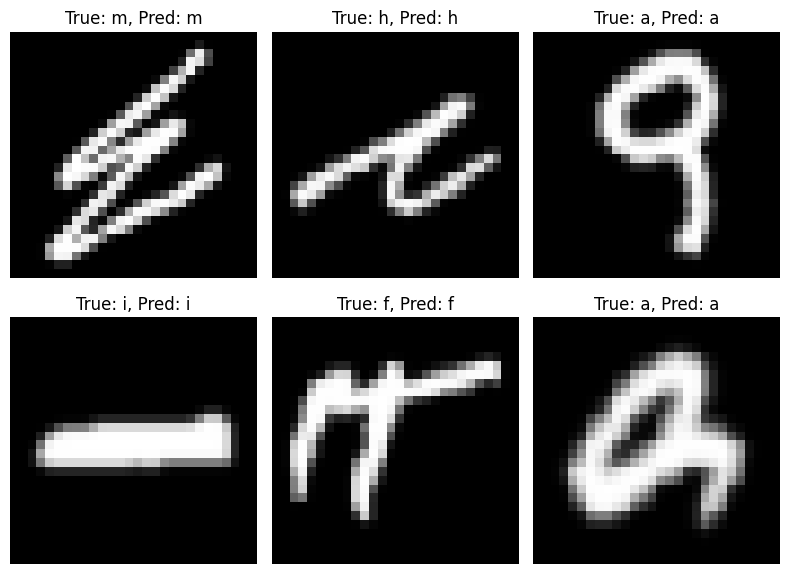

In [46]:
for images, labels in ds_test.take(1):
    predictions = model(images)
    pred_labels = tf.argmax(predictions, axis=1)
    
    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    for i in range(6):
        ax = axes[i // 3, i % 3]
        ax.imshow(tf.squeeze(images[i]), cmap='gray')
        ax.set_title(f'True: {label_to_char[labels[i].numpy()]}, Pred: {label_to_char[pred_labels[i].numpy()]}')

        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Save Model

In [47]:
model.save("emnist_model.keras")

## Model Wrap

### LittleRTModule

In [48]:
class LiteRTModule(tf.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    @tf.function(input_signature=[
        tf.TensorSpec([None, 28, 28, 1], tf.float32),
        tf.TensorSpec([None], tf.int32)
    ])
    def train(self, x, y):
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss = self.loss_fn(y, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return {"loss": loss}

    @tf.function(input_signature=[
        tf.TensorSpec([None, 28, 28, 1], tf.float32)
    ])
    def infer(self, x):
        probs = self.model(x, training=False)
        return {"probs": probs}

### Create Wraped Model

In [54]:
litert_module = LiteRTModule(model)

### Save Model with Signatures

In [55]:
tf.saved_model.save(
    litert_module,
    "saved_model",
    signatures={
        'train': litert_module.train.get_concrete_function(),
        'infer': litert_module.infer.get_concrete_function()
    }
)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


### Convert to TFLitle

In [56]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

with open("emnist_litert_model_FIXED.tflite", "wb") as f:
    f.write(tflite_model)

In [32]:
model = tf.keras.models.load_model("emnist_model.keras")

t_converter = tf.lite.TFLiteConverter.from_keras_model(model)

t_converter.experimental_enable_resource_variables = False

t_converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
test_tflite_model = t_converter.convert()

with open("test_emnist_model_infer_only.tflite", "wb") as f:
    f.write(test_tflite_model)


INFO:tensorflow:Assets written to: C:\Users\arnau\AppData\Local\Temp\tmpz82zuf4k\assets


INFO:tensorflow:Assets written to: C:\Users\arnau\AppData\Local\Temp\tmpz82zuf4k\assets


Saved artifact at 'C:\Users\arnau\AppData\Local\Temp\tmpz82zuf4k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2174594259216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2174580618448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2174580615376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2174580609232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2174580615568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2174585649104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2174585648336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2174585647760: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Comparation

In [34]:
interpreter = tf.lite.Interpreter(model_path="test_emnist_model_infer_only.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

c:\Users\arnau\Uni\Master\1B UniTn\IoT\Project\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [38]:
x_all = []
y_all = []
for x_batch, y_batch in ds_test.take(2):  # 2 batches = 128 samples
    x_all.append(x_batch.numpy())
    y_all.append(y_batch.numpy())

x = np.concatenate(x_all, axis=0)
y = np.concatenate(y_all, axis=0)

num_samples = 100  # Set desired test size

# --- Run predictions ---
keras_logits = model.predict(x[:num_samples])
tflite_logits = []

for i in range(num_samples):
    sample = np.expand_dims(x[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])[0]
    tflite_logits.append(output)

tflite_logits = np.array(tflite_logits)

# --- Accuracy ---
keras_preds = np.argmax(keras_logits, axis=1)
tflite_preds = np.argmax(tflite_logits, axis=1)
keras_correct = np.sum(keras_preds == y[:num_samples])
tflite_correct = np.sum(tflite_preds == y[:num_samples])

# --- Differences ---
avg_diff = np.mean(np.abs(keras_logits - tflite_logits))
max_diff = np.max(np.abs(keras_logits - tflite_logits))

# --- Report ---
print("📊 Model Comparison Summary")
print(f"✅ Keras Accuracy:      {keras_correct / num_samples:.4f}")
print(f"✅ TFLite Accuracy:     {tflite_correct / num_samples:.4f}")
print(f"📉 Avg Logit Delta:     {avg_diff:.2e}")
print(f"📈 Max Logit Delta:     {max_diff:.2e}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
📊 Model Comparison Summary
✅ Keras Accuracy:      0.9000
✅ TFLite Accuracy:     0.9000
📉 Avg Logit Delta:     7.05e-09
📈 Max Logit Delta:     1.01e-06
